                         load  temperature  price  hour  dayofweek  \
time                                                                 
2018-11-01 00:00:00  48879.50          5.0  40.86     0          3   
2018-11-01 01:00:00  47312.50          4.9  40.86     1          3   
2018-11-01 02:00:00  46093.75          5.1  41.10     2          3   
2018-11-01 03:00:00  46710.50          4.9  40.59     3          3   
2018-11-01 04:00:00  47624.25          4.2  40.09     4          3   

                     is_weekend  is_holiday  is_low  
time                                                 
2018-11-01 00:00:00           0           0       0  
2018-11-01 01:00:00           0           0       0  
2018-11-01 02:00:00           0           0       0  
2018-11-01 03:00:00           0           0       0  
2018-11-01 04:00:00           0           0       0  
Number of data points in the interval: 1464


c:\Users\fanek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\fanek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\fanek\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA Summary:
                                       SARIMAX Results                                       
Dep. Variable:                                     y   No. Observations:                 1098
Model:             SARIMAX(0, 0, 3)x(1, 0, [1], 168)   Log Likelihood                 969.707
Date:                               Mon, 27 Jan 2025   AIC                          -1911.413
Time:                                       02:59:54   BIC                          -1841.396
Sample:                                   11-01-2023   HQIC                         -1884.923
                                        - 12-16-2023                                         
Covariance Type:                                 opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
hour               0.0050      0.001      3.632      0.000       0

[]

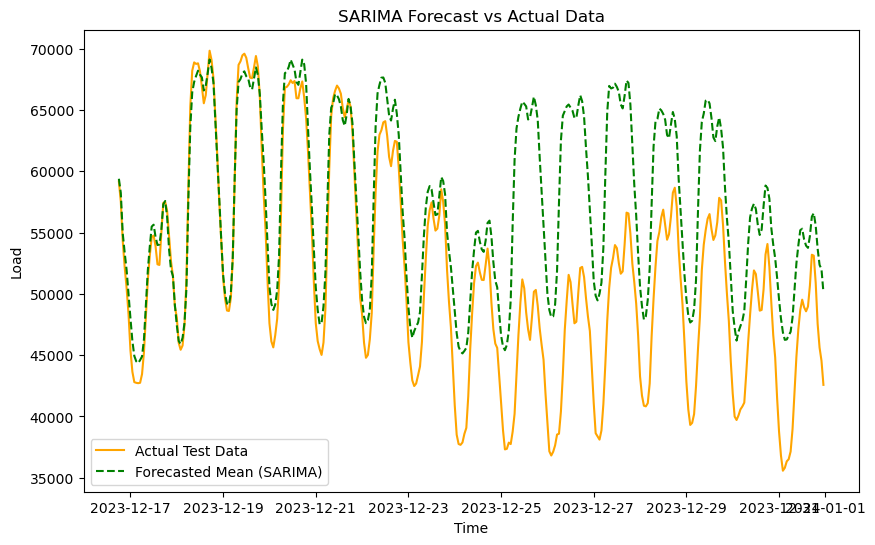

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import math as mat
from sklearn.preprocessing import StandardScaler

# Load CSV file
file_path = r"C:\User\...\hourly_merged_data.csv" ## Use the avg_hourly_processed_data_with_features found in the Data file
daily_df = pd.read_csv(file_path, parse_dates=['time'], dayfirst=True)

# To convert 'time' column to datetime and set as index
daily_df['time'] = pd.to_datetime(daily_df['time'])
daily_df.set_index('time', inplace=True)

#To  add new features to capture seasonal effects
daily_df['hour'] = daily_df.index.hour  # Extract hour of the day
daily_df['dayofweek'] = daily_df.index.dayofweek  # Extract day of the week (0=Monday, 6=Sunday)
daily_df['is_weekend'] = daily_df['dayofweek'] >= 5  # Boolean for weekends (Saturday/Sunday)

# To capture the holiday effects - 
holidays = ['2022-12-25', # Holidays for 2022 and 2023
            '2023-01-01', '2023-12-25'] 

daily_df['is_holiday'] = daily_df.index.date.astype(str)  # Convert to string format
daily_df['is_holiday'] = daily_df['is_holiday'].isin(holidays)  # Use .isin() on the pandas Series

# To convert boolean columns to 1 and 0
daily_df['is_weekend'] = daily_df['is_weekend'].astype(int)
daily_df['is_holiday'] = daily_df['is_holiday'].astype(int)


# To generate a feature for peak season 
pick_season = [  
    ('2023-12-01', '2023-12-31')  
]

high = []
for start, end in pick_season:
    high += pd.date_range(start=start, end=end, freq='D').strftime('%Y-%m-%d').tolist()

# To convert the datetime index to string for comparison
daily_df['is_low'] = daily_df.index.date.astype(str)

# To mark the holiday dates directly in the 'is_holiday' column without using isin
daily_df['is_low'] = daily_df['is_low'].apply(lambda x: 1 if x in high else 0) # create boolean
print(daily_df.head()) 

load_time_temp=daily_df['temperature']*daily_df['load']
y=np.mean(load_time_temp)
z = load_time_temp.quantile(0.80)
daily_df['load_time_temp']=load_time_temp.apply(lambda x: 1 if x<=z else 0)
daily_df['is_high_load']=daily_df['load'].apply(lambda x: 1 if x>55000 else 0)

# To take a subset of the data for quicker testing
daily_df_subset = daily_df.loc['2023-11-01':'2023-12-31', ['load', 'hour', 'is_weekend', 'is_holiday', 'is_low', 'price', 'temperature', 'is_high_load', 'load_time_temp']] # removed 'hour'
# # Count the number of data points in the subset
num_data_points = daily_df_subset.shape[0]
# x is used below to devide the data into training and testing
x=mat.floor(num_data_points*0.75)
print(f"Number of data points in the interval: {num_data_points}")


# To define training and testing datasets
train_data = daily_df_subset['load'][:x]  # Use only the first x observations for training 
test_data = daily_df_subset['load'][x:]  # Use the rest for testing

# To standardize the data (Reshaping required for StandardScaler)
scaler = StandardScaler()

# To correct reshaping: transform into 2D array for StandardScaler
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1)).flatten()
scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1)).flatten()

# To use the optimal model parameters based on previous ARIMA output
p, d, q = 0, 0, 3
P, D, Q, s = 1, 0, 1, 24*7 

# To fit the SARIMA model with external regressors (using the training data)
mod = SARIMAX(
    scaled_train_data, 
    order=(p, d, q), 
    seasonal_order=(P, D, Q, s), 
    exog=daily_df_subset[['hour', 'is_weekend', 'is_holiday','is_low', 'price', 'temperature', 'is_high_load', 'load_time_temp']][:x]  # External regressors for training data// Made change here
)
sarima_result = mod.fit(disp=False)

# Print SARIMA model summary
print("SARIMA Summary:")
print(sarima_result.summary())

# To forecast with SARIMA
forecast = sarima_result.get_forecast(steps=len(scaled_test_data), exog=daily_df_subset[['hour', 'is_weekend', 'is_holiday','is_low', 'price', 'temperature', 'is_high_load', 'load_time_temp']][x:]) # Made change here
forecast_mean = forecast.predicted_mean

# To rescale SARIMA forecast mean to original scale
forecast_mean_rescaled = scaler.inverse_transform(forecast_mean.values.reshape(-1, 1)).flatten()

# and the actual test data
test_rescaled = scaler.inverse_transform(scaled_test_data.reshape(-1, 1)).flatten()

# To plot forecast vs actual data
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_rescaled, label='Actual Test Data', color='orange')
plt.plot(test_data.index, forecast_mean_rescaled, label='Forecasted Mean (SARIMA)', color='green', linestyle='--')
plt.title('SARIMA Forecast vs Actual Data')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
# plt.savefig('sarima_forecast_vs_actual.png')
plt.plot()